In [29]:
!pip install boto3 -q
!pip install opencv-python torch numpy torchvision

## Download the data

The data for this assignment has been made available and is downloadable to disk by running the below cell.

In [30]:
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import os

# Connect to S3 without authentication (public bucket)
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

bucket_name = 'prism-mvta'
prefix = 'training-and-validation-data/'
download_dir = './video-data'

os.makedirs(download_dir, exist_ok=True)

# List all objects in the S3 path
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=bucket_name, Prefix=prefix)

video_names = []

for page in pages:
    if 'Contents' not in page:
        print("No files found at the specified path! Go and complain to the TAs!")
        break

    for obj in page['Contents']:
        key = obj['Key']
        filename = os.path.basename(key)

        if not filename:
            continue

        video_names.append(filename)

        local_path = os.path.join(download_dir, filename)
        print(f"Downloading: {filename}")
        s3.download_file(bucket_name, key, local_path)

print("\n" + "="*50)
print("Downloaded videos:")
print("="*50)
for name in video_names:
    print(name)

print(f"\nTotal: {len(video_names)} files")

Downloading: 1_dksksjfwijf.mp4
Downloading: 2_dfsaeklnvvalkej.mp4
Downloading: 2_difficult_2.mp4
Downloading: 2_difficult_sdafkljsalkfj.mp4
Downloading: 2_dkdjwkndkfw.mp4
Downloading: 2_dkdmkejkeimdh.mp4
Downloading: 2_dkjd823kjf.mp4
Downloading: 2_dsalkfjalwkenlke.mp4
Downloading: 2_kling_20251205_Text_to_Video_On_a_sandy_4976_0.mp4
Downloading: 2_kling_20251206_Text_to_Video_Generate_a_71_1.mp4
Downloading: 2_sadfasjldkfjaseifj.mp4
Downloading: 2_sdafkjaslkclaksdjkas.mp4
Downloading: 2_sdfkjsaleijflaskdjf.mp4
Downloading: 2_sdjfhafsldkjhjk.mp4
Downloading: 2_sdkjdsflkjfwa.mp4
Downloading: 2_sdlfjlewlkjkj.mp4
Downloading: 2_sdlkjsaelijfksdjf.mp4
Downloading: 3_asldkfjalwieaskdfaskdf.mp4
Downloading: 3_dkk873lkjlksajdf.mp4
Downloading: 3_dsjlaeijlksjdfie.mp4
Downloading: 3_dsksdfjbvsdkj.mp4
Downloading: 3_dslkaldskjflakjs.mp4
Downloading: 3_ewdfkjwaeoihjlkasdjf.mp4
Downloading: 3_kling_20251205_Text_to_Video_In_a_grass_4697_0.mp4
Downloading: 3_kling_20251205_Text_to_Video_On_a_playg_5

These videos are now available in the folder "video-data". You can click on the folder icon on the left-hand-side of this screen to see the videos in a file explorer.

# Create your Datasets and Dataloaders

Some example code for approaching the first *two* TODOs is given below just to get you started. No starter code is given for the third TODO.

Note, the below code is very rough skeleton code. Make no assumptions as to the correct manner to architect your model based on the structure of this code.

Please feel free to (if not encouraged to) change every single line of the below code (change it to best suit your chosen model architecture, in the next section).

### TODO 1 (This is mostly already done for you - Please see the v1 provided below)

Each video in the folder is prefixed by a number. That number corresponds to the number of distinct pushups visible in the video. Write code to iterate over each video in the folder, and extract the corresponding target associated with the video.

### TODO 2 (This is also mostly already done for you - Please see the v1 provided below)


Divide the data into training and validation sets.

Optionally, you can also create out your own test set to assess your performance.

### TODO 3

Any preprocessing or augmentation of your data which you deem required, should (probably) go here. You are also free to include your data-augmentation code later, though doing it before creating your dataloaders is probably a good idea.

If you complete this TODO, to maintain experimental hygiene, feel free to modify the code which was provided for TODOs 1 and 2.

In [31]:
# Here is a basic implementation of the above two TODOs. You can assume the first TODO is completed correctly.

# Please modify this code to suit you best, as you decide on your preferred model architecture.

# For example, below here we are padding every video to 1,000 frames. That may or may not be a good idea.


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
import cv2
import numpy as np
import random
import torch.nn.functional as F
from torchvision.models.video import R2Plus1D_18_Weights

weights = R2Plus1D_18_Weights.DEFAULT
preprocess = weights.transforms()

class Augmentation:
  """
  Simple Augmentation for the video; applies flip, brightness, noise and cutout.
  """
  def __init__(self, p=0.3):
    self.p = p

  def __call__(self, frames):


    if random.random() < self.p:
      #Horizontal flip
      frames = torch.flip(frames, dims=[3]) #flips the W

    if random.random() < self.p:
      #Random brightness
      brightness = 1.0 + random.uniform(-0.2, 0.2)
      frames = torch.clamp(frames * brightness, 0, 1)

    if random.random() < self.p:
      #Add noise
      noise = torch.randn_like(frames) * 0.02
      frames = torch.clamp(frames + noise, 0, 1)

    if random.random() < 0.2:
      #Cutout
      C, T, H, W = frames.shape
      cutout_size = H // 6
      x = random.randint(0, H - cutout_size)
      y = random.randint(0, W - cutout_size)

      frames[:,:, x:x+cutout_size, y:y+cutout_size] = 0

    if random.random() < self.p:
      #Random Translation
      C,T, H, W = frames.shape
      max_shift = 8 #num of pixels
      dx = random.randint(-max_shift, max_shift)
      dy = random.randint(-max_shift, max_shift)

      #pad and crop to the original size
      frames = F.pad(frames, (max_shift, max_shift, max_shift, max_shift))
      frames = frames[:, :, (max_shift+dy):(max_shift+dy+H), (max_shift+dx):(max_shift+dx+W)]

    return frames


class VideoDataset(Dataset):
    """Dataset for loading videos from a folder. Labels from filename prefix."""

    def __init__(self, video_dir, frame_size=(112, 112), target_frames=16, augment=None, do_preprocess=True):
        self.video_dir = video_dir
        self.frame_size = frame_size
        self.target_frames = target_frames
        self.augment = augment
        self.do_preprocess = do_preprocess

        self.video_files = [f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))]
        self.labels = [int(f.split('_')[0]) - 1 for f in self.video_files] 

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_files[idx])
        frames = self._load_video(video_path)
        label = self.labels[idx]

        if self.augment:
            frames = self.augment(frames)
        
        if self.do_preprocess:
           x = frames.permute(1,0,2,3)
           x = preprocess(x)
           frames = x.permute(1,0,2,3)

        return frames, label

    def _load_video(self, path, target_frames=16):
        cap = cv2.VideoCapture(path)
        all_frames = []

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            all_frames.append(frame)

        cap.release()

        T = self.target_frames
        H, W = self.frame_size

        if len(all_frames) == 0:
            return torch.zeros(3, T, H, W)

        idxs = np.linspace(0, len(all_frames) - 1, T).astype(int)
        sampled = [cv2.resize(all_frames[i], (W, H)) for i in idxs]

        frames = torch.from_numpy(np.array(sampled)).permute(3, 0, 1, 2).float() / 255.0

        return frames


def collate_fn(batch):
    frames_list, labels = zip(*batch)
    frames = torch.stack(frames_list)
    frames = frames.permute(0, 2, 1, 3, 4)
    labels = torch.tensor(labels)

    return frames, labels


def get_dataloaders(video_dir, batch_size=4, val_split=0.2, frame_size=(112, 112), target_frames=16):
    """Create train and validation dataloaders."""

    files = sorted([f for f in os.listdir(video_dir) if f.endswith(('.mp4', '.avi', '.mov'))])

    train_dataset_full = VideoDataset(
        video_dir,
        frame_size=frame_size,
        target_frames=target_frames,
        augment=Augmentation(p=0.5),
        do_preprocess=True
    )
    train_dataset_full.video_files = files
    train_dataset_full.labels = [int(f.split('_')[0]) - 1 for f in files]

    val_dataset_full = VideoDataset(
        video_dir,
        frame_size=frame_size,
        target_frames=target_frames,
        augment=None,
        do_preprocess=True
    )
    val_dataset_full.video_files = files
    val_dataset_full.labels = [int(f.split('_')[0]) - 1 for f in files]

    val_size = int(len(files) * val_split)
    train_size = len(files) - val_size

    gen = torch.Generator().manual_seed(42)
    train_idx, val_idx = random_split(range(len(files)), [train_size, val_size], generator=gen)

    train_dataset = torch.utils.data.Subset(train_dataset_full, train_idx.indices)
    val_dataset   = torch.utils.data.Subset(val_dataset_full, val_idx.indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=0, collate_fn=collate_fn)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

    print(f"Train: {len(train_dataset)} videos, Val: {len(val_dataset)} videos\n")
    return train_loader, val_loader


video_dir = './video-data'

train_loader, val_loader = get_dataloaders(video_dir, batch_size=4, val_split=0.2)

for frames, labels in train_loader:
    print(f"Frames shape: {frames.shape}")  # (B, C, 1000, H, W)
    print(f"Labels: {labels}")
    break

Train: 62 videos, Val: 15 videos

Frames shape: torch.Size([4, 3, 16, 112, 112])
Labels: tensor([3, 2, 1, 1])


# Create a Model

For this assignment, we request you use PyTorch. Below is an example of how to instantiate a very basic PyTorch model.

Note, this model below needs a _lot_ of work.

Please include your code for creating your model below.

The only constraint here is that you define a Python object which inherits from a PyTorch nn.Module object. Beyond that, please feel free to implement anything you like: Transformer, Vision Transformer, MLP, CNN, etc.

### TODO 4

Create your model.

In [45]:
labels = []
for f in os.listdir("./video-data"):
    if f.endswith(".mp4"):
        labels.append(int(f.split("_")[0]) - 1)
print("num_classes:", len(set(labels)))

num_classes: 7


In [46]:
import torch
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, R2Plus1D_18_Weights

#Downloads the pretrained  model
num_classes = 7
weights = R2Plus1D_18_Weights.DEFAULT
model = r2plus1d_18(weights=weights)

#Swaps the last layer so it outputs 8 logits
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

for p in model.parameters():
    p.requires_grad = False
for p in model.layer4.parameters():
    p.requires_grad = True
for p in model.fc.parameters():
    p.requires_grad = True

print(model.fc)

Linear(in_features=512, out_features=7, bias=True)


In [47]:
device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
model = model.to(device)

frames, labels = next(iter(train_loader))
frames = frames.to(device)
out = model(frames)

print(frames.shape)
print(out.shape)

torch.Size([4, 3, 16, 112, 112])
torch.Size([4, 7])


# Train your Model

### TODO 5

Training time! Please include your training code below.

As per above, please feel free (and encouraged) to rip out all of the below code and replace with your (much better) code.

The below should just be used as an example to get you started.

In [48]:
import torch.optim as optim
import torch.nn as nn

def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for frames, labels in train_loader:
        frames = frames.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    acc = correct / total
    return avg_loss, acc


def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for frames, labels in val_loader:
            frames = frames.to(device)
            labels = labels.to(device)

            outputs = model(frames)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    acc = correct / total
    return avg_loss, acc


def train_model(model, train_loader, val_loader, epochs, lr, weight_decay):
    device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
    print(f"Using device: {device}\n")

    model = model.to(device)
    optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)


    criterion = nn.CrossEntropyLoss()

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return model

In [49]:
# setting a manual seed for reproducibility
torch.manual_seed(0)
model = train_model(model, train_loader, val_loader, epochs=8, lr=1e-4, weight_decay=1e-4)

Using device: mps

Epoch 1/8 | Train Loss: 2.3855, Train Acc: 0.0484 | Val Loss: 2.2096, Val Acc: 0.1333
Epoch 2/8 | Train Loss: 1.2478, Train Acc: 0.6613 | Val Loss: 1.7582, Val Acc: 0.4000
Epoch 3/8 | Train Loss: 0.7561, Train Acc: 0.8226 | Val Loss: 1.7448, Val Acc: 0.5333
Epoch 4/8 | Train Loss: 0.5713, Train Acc: 0.7903 | Val Loss: 1.6212, Val Acc: 0.4000
Epoch 5/8 | Train Loss: 0.4486, Train Acc: 0.8710 | Val Loss: 1.9241, Val Acc: 0.4667
Epoch 6/8 | Train Loss: 0.5589, Train Acc: 0.8871 | Val Loss: 2.0997, Val Acc: 0.4667
Epoch 7/8 | Train Loss: 0.4059, Train Acc: 0.8710 | Val Loss: 2.0133, Val Acc: 0.5333
Epoch 8/8 | Train Loss: 0.2337, Train Acc: 0.9516 | Val Loss: 1.8039, Val Acc: 0.5333


# Evaluation

## TODO 6

Include any code which you feel is useful for evaluating your model performance below.

In [52]:
import numpy as np

def collect_preds(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for frames, labels in loader:
            frames = frames.to(device)
            labels = labels.to(device)

            logits = model(frames)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)
    y_prob = np.concatenate(all_probs)
    return y_true, y_pred, y_prob

y_true, y_pred, y_prob = collect_preds(model, val_loader, device)

acc = (y_pred == y_true).mean()
print(f"Validation accuracy: {acc:.3f}  ({(y_pred==y_true).sum()}/{len(y_true)})")


Validation accuracy: 0.533  (8/15)


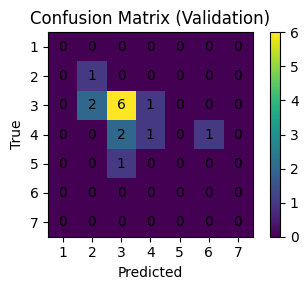

Confusion matrix:
 [[0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 2 6 1 0 0 0]
 [0 0 2 1 0 1 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [54]:
import matplotlib.pyplot as plt

def confusion_matrix_np(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

num_classes = 7
class_names = [str(i) for i in range(1, 8)]

cm = confusion_matrix_np(y_true, y_pred, num_classes)

plt.figure(figsize=(4, 3))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(num_classes), class_names)
plt.yticks(range(num_classes), class_names)

# write counts in cells
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()

print("Confusion matrix:\n", cm)


In [55]:
per_class_total = cm.sum(axis=1)
per_class_correct = np.diag(cm)
per_class_acc = np.divide(per_class_correct, per_class_total, out=np.zeros_like(per_class_correct, dtype=float), where=per_class_total!=0)

for i, a in enumerate(per_class_acc):
    print(f"Class {class_names[i]}: {a:.3f}  ({per_class_correct[i]}/{per_class_total[i]})")

print(f"\nMacro avg acc: {per_class_acc.mean():.3f}")


Class 1: 0.000  (0/0)
Class 2: 1.000  (1/1)
Class 3: 0.667  (6/9)
Class 4: 0.250  (1/4)
Class 5: 0.000  (0/1)
Class 6: 0.000  (0/0)
Class 7: 0.000  (0/0)

Macro avg acc: 0.274


# Hugging Face

It is a requirement of this assignment that you submit your trained model to a repo on Hugging Face, and make it publicly available. Below, we provide code which should help you do this.

## TODO 7

Upload your model to HuggingFace

Install the dependencies:

In [56]:
!pip install huggingface_hub

You'll now need to log in to Hugging Face via the command line. To do this, you'll need to generate a token on your Hugging Face account. To generate a token, run the below command, and click on the link which appears.

In [57]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): ^C
Traceback (most recent call last):
  File "/opt/miniconda3/bin/hf", line 8, in <module>
    sys.exit(main())
  File "/opt/miniconda3/lib/python3.13/site-packages/huggingface_hub/cli/hf.py", line 59, in main
    service.run()
  File "/opt/miniconda3/lib/python3.13/site-pac

The below code will only run if you have already trained a model with variable name 'model'.

The below code will take your trained model, and upload it to a *public* HuggingFace repo in your account called "mv-final-assignment".

(Note - in this example, we have set 'private=False' in the upload_to_hub method. This makes your model public).

You should double-check that your model is in fact public. To do that, you can navigate (in an incognito tab, in a browser) to https://huggingface.co/YOUR_USERNAME/YOUR_MODEL_NAME and see if that page loads. If your model is public, it will. (Simply being able to run the below code will not guarantee that your model is in fact public, because, you have now authenticated yourself with the huggingface CLI).

In [58]:
# YOUR HUGGING FACE USERNAME BELOW
hf_username = 'EleftheriaK'

In [ ]:
import torch
import torch.nn as nn
from huggingface_hub import HfApi, hf_hub_download


def save_model(model, path="model.pt"):
    """Save the model weights to a file."""
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def upload_to_hub(local_path="model.pt", repo_id=f"{hf_username}/mv-final-assignment"):
    """
    Upload model to Hugging Face Hub.

    Args:
        local_path: Path to your saved model file
        repo_id: Your repo in format "username/model-name"
    """
    api = HfApi()

    # Create the repo first (if it already exists, this will just skip)
    api.create_repo(
        repo_id=repo_id,
        repo_type="model",
        exist_ok=True,  # Don't error if it already exists
        private=False,  # Make it public so TAs can access
    )

    # Now upload the file
    api.upload_file(
        path_or_fileobj=local_path,
        path_in_repo="model.pt",
        repo_id=repo_id,
        repo_type="model",
    )

    print(f"Model uploaded to https://huggingface.co/{repo_id}")


# =============================================================================
# EXAMPLE USAGE
# =============================================================================

if __name__ == "__main__":

    save_model(model, "mv-final-assignment.pt")

    upload_to_hub("mv-final-assignment.pt", f"{hf_username}/mv-final-assignment")


/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model saved to mv-final-assignment.pt


Processing Files (0 / 1):  31%|███       | 38.5MB /  125MB,  612kB/s  